In [1]:
import cv2
import numpy as np
import math
import os
from PIL import Image
import pandas as pd
from sklearn import metrics
import time
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Initializing
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

#Loading the ground truth values from file 
groundtruth = pd.read_csv("Groundtruth.csv")

#Loading COCO class labels which YOLO was trained on
labelsPath = os.path.sep.join(["coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

weightsPath = "yolov4-tiny.weights"
configPath = "yolov4-tiny.cfg"

#Loading YOLO model - [1]
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath) #Load YOLO model to Open CV 
ln = net.getLayerNames() #Get names of all layers used in the network
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()] #Gets index of the output layers

## TASK 1 - Identify & count cars in each frame

In [3]:
def detect_cars(obj):
    # Detect cars function takes in the class id passed to it and returns 1 if the corresponding label from the COCO dataset 
    # for that class id car else it returns 0   
    
    if(LABELS[obj]=="car"):
        return 1
    else:
        return 0

In [4]:
## TASK 1 - [1]

#Initialize
total_cars = []
time_per_frame = []
frame_per_second = []
count = 0
               
query_start = time.perf_counter()

#reading Video clip from local
cap = cv2.VideoCapture('assignment-clip.mp4')
start = time.perf_counter()

try:
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #saving the total number of frames in the video
except:
    print("Could not determine # of frames in video")

while cap.isOpened():
    frame_returned, frame = cap.read()
    car_count = 0
        
    if frame_returned: 
        complete_status = (count/total)*100
        if(count == 0):
            print("Processing Video..")
            print("**",count,"% completed **")
        elif(complete_status % 25 == 0):
            print("**",complete_status,"% completed **")
        frame_start = time.perf_counter()
        
        H, W = frame.shape[:2]
        
        #create 4D blob from input frame & do a forward pass of YOLO
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln) 
        
        boxes = []
        confidences = []
        classIDs = []
     
        # loop over each layer outputs
        for output in layerOutputs:

            # loop over each of detected objects
            for detection in output:

                # extract the class id (label) and confidence (as a probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                #checking if the confidence found by YOLO is greater than set confidence value of 0.5
                if confidence > CONFIDENCE: 
                    #getting the box coordinates for the detected object
                    box = detection[0:4] * np.array([W, H, W, H])  
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

        #checking if a detection exisits in the frame
        if len(idxs) > 0:

            # loop over the indexes we are keeping
            for i in idxs.flatten():
                car_count += detect_cars(classIDs[i])
        
        total_cars.append(car_count)
        
        #calculating elapsed time
        elapsed_time = time.perf_counter() - start
        fps = count / elapsed_time
        time_per_frame.append(elapsed_time)
        frame_per_second.append(fps)
        
        count += 1 
        cap.set(1, count) #this advances the video by one second
    else:
        cap.release()
        print("**",(count*100)/total,"% completed **")
        break

#writing output to a csv file        
output1 = pd.DataFrame(columns = ['Total Cars'])
output1['Total Cars']=total_cars
task1_output = pd.DataFrame(output1)
task1_output.to_csv("Devishree_task1_output.csv",mode='w+')

query_end = time.perf_counter()
print("Task 1: Average Throughput is ",round((sum(frame_per_second))/total,2)," frames processed per second")
print("Task 1: Time taken to execute full query: ",round(query_end-query_start,2)," seconds")

Processing Video..
** 0 % completed **
** 25.0 % completed **
** 50.0 % completed **
** 75.0 % completed **
** 100.0 % completed **
Task 1: Average Throughput is  6.58  frames processed per second
Task 1: Time taken to execute full query:  133.2  seconds


In [5]:
y_truth = groundtruth['Total'].values
y_pred = np.array(total_cars)

In [28]:
def calculate_f1(y_truth,y_pred):
    #Calculate F1 function calculates the f1 for the given predicted and ground truth values. 
    
    total_frames = len(y_truth)
    p = np.empty(total_frames)
    r = np.empty(total_frames)
    TP = 0
    FP = 0
    FN = 0

    for i in range(total_frames):
        if(y_pred[i]-y_truth[i] == 0):
            TP = y_pred[i]
        elif(y_pred[i] - y_truth[i] > 0):
            TP = y_truth[i]
            FP = y_pred[i] - y_truth[i]
        elif(y_pred[i] - y_truth[i] < 0):
            TP = y_pred[i]
            FN = y_truth[i] - y_pred[i]
        p[i] = TP/(TP + ~np.isnan(FP))
        r[i] = TP/(TP + ~np.isnan(FN))

    Precision = sum(p)/total_frames
    Recall = sum(r)/total_frames
    F1_score = (2 * Precision * Recall)/(Precision + Recall)
    return F1_score

In [7]:
print("Task 1: F1 score =",round(calculate_f1(y_truth,y_pred),2))

Task 1: F1 score = 0.69


In [8]:
#Calculating Accuracy of the model
Total_accr = metrics.accuracy_score(y_truth, y_pred)*100
print("Task 1: Total car count Accuracy =",round(Total_accr,2),"%")

Task 1: Total car count Accuracy = 49.44 %


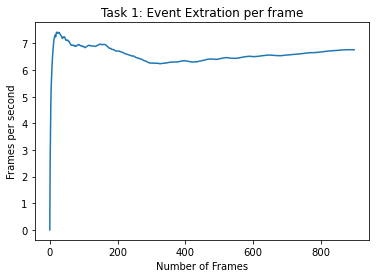

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(0,total),frame_per_second)
plt.title('Task 1: Event Extration per frame')
plt.xlabel('Number of Frames')
plt.ylabel('Frames per second')
plt.show()

## Task 2: Identify and count the cars and their types in each frame

#### Data Preparation 

In [ ]:
# Bing Image Downloader - [2]

# pip install bing_image_downloader

# from bing_image_downloader import downloader

# downloader.download("suv cars", limit=400,  output_dir='dataset_new', adult_filter_off=True, force_replace=False, timeout=60)
# downloader.download("sedan cars", limit=400,  output_dir='dataset_new', adult_filter_off=True, force_replace=False, timeout=60)

In [ ]:
# Simple Image Downloader - [3]

# pip install simple_image_download

# from simple_image_download import simple_image_download as simp

# response = simp.simple_image_download

# response().download('suv', 300)
# response().download('sedan', 300)

In [10]:
#Load custom image dataset from local - [4]
from pathlib import Path

dataset_path = "dataset"

dataset_path = Path(dataset_path)

sedan = list(dataset_path.glob('sedan/*'))
suv = list(dataset_path.glob('suv/*'))

car_images_dict = {
    'suv': list(dataset_path.glob('suv/*')),
    'sedan': list(dataset_path.glob('sedan/*'))
}

car_model_dict = {
    'suv': 0,
    'sedan': 1
}

model_key_list = list(car_model_dict.keys())
model_value_list = list(car_model_dict.values())

In [11]:
#Splitting images and labels into X and y for training purposes - [4]
X, y = [], []

for model_name, images in car_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        try:
            resized_img = cv2.resize(img,(224,224),cv2.INTER_AREA) #resizing image so that image shape is same as Keras MobileNet pree-trained model
            X.append(resized_img)
            y.append(car_model_dict[model_name])
        except:
            break

X = np.array(X)
X_scaled = X/255.0 #scaling the image array so that all values are between 0 & 1
y = np.array(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=0)

In [12]:
#Getting pre-trained model which extracts features - [4]
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

#Setting up model 
model = tf.keras.Sequential([
  pretrained_model_without_top_layer, #pretrained MobileNet model
  layers.Flatten(),    #flatten output into a single vector
  layers.Dense(128, activation='relu'), #fully connected layer
  tf.keras.layers.Dense(2) 
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #since data is labelled as integers 0 & 1
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#Training model on custom image dataset           
model.fit(X_train, y_train, epochs=15)

Epoch 1/15
23/23 [==============================] - 28s 827ms/step - loss: 0.6695 - accuracy: 0.6460
Epoch 2/15
23/23 [==============================] - 19s 814ms/step - loss: 0.3242 - accuracy: 0.8717
Epoch 3/15
23/23 [==============================] - 19s 822ms/step - loss: 0.1927 - accuracy: 0.9335
Epoch 4/15
23/23 [==============================] - 19s 839ms/step - loss: 0.1268 - accuracy: 0.9689
Epoch 5/15
23/23 [==============================] - 19s 827ms/step - loss: 0.0956 - accuracy: 0.9861
Epoch 6/15
23/23 [==============================] - 19s 825ms/step - loss: 0.0665 - accuracy: 0.9878
Epoch 7/15
23/23 [==============================] - 19s 833ms/step - loss: 0.0528 - accuracy: 0.9882
Epoch 8/15
23/23 [==============================] - 19s 821ms/step - loss: 0.0491 - accuracy: 0.9845
Epoch 9/15
23/23 [==============================] - 19s 818ms/step - loss: 0.0340 - accuracy: 0.9955
Epoch 10/15
23/23 [==============================] - 19s 809ms/step - loss: 0.0299 - accura

In [14]:
#Testing model on Validation set
print("Validation set")
model.evaluate(X_val,y_val)

#Testing model on Test set
print("Test set")
model.evaluate(X_test,y_test)

Validation set
6/6 [==============================] - 6s 752ms/step - loss: 0.2517 - accuracy: 0.9558
Test set
8/8 [==============================] - 6s 719ms/step - loss: 0.1475 - accuracy: 0.9559


[0.14753930270671844, 0.9559471607208252]

In [15]:
def predict_model(img):
    #Predict model function resizes the input image and sends the image with padding to the Keras model's predict function.
    #The max probability of the Keras model's result is considered as the predicted class. 
    #The output of this function is to return the car model name from the predicted class.
    
    while True:
        try:
            img = cv2.resize(img,(224,224),cv2.INTER_AREA) #resizing cropped image from the frame
            result = model.predict(img[np.newaxis, ...]) #adding a padding to the image before calling the predict function
            predicted_label_index = np.argmax(result) #selecting the label with the most probability
            model_name = model_key_list[model_value_list.index(predicted_label_index)]
            return model_name
        except:
            break

In [29]:
## Task 2: - [1]

#Initialization
count = 0
total_cars = []
total_suv = []
total_sedan = []
time_per_frame = []
frame_per_second = []
query_start = time.perf_counter()

cap = cv2.VideoCapture('assignment-clip.mp4')
start = time.perf_counter()

try:
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
except:
    print("Could not determine # of frames in video")

#initialization for writing output of each frame into a mp4 video       
_, frame = cap.read()
h, w = frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
out = cv2.VideoWriter("Devishree_Assignment1_video.mp4", fourcc, 20.0, (w, h))

while cap.isOpened():
    frame_returned, frame = cap.read()
    sedan_count = 0
    suv_count = 0
        
    if frame_returned: 
        complete_status = (count/total)*100
        if(count == 0):
            print("Processing Video..")
            print("**",count,"% completed **")
        elif(complete_status % 25 == 0):
            print("**",complete_status,"% completed **")
        frame_start = time.perf_counter()
        
        H, W = frame.shape[:2]
        
        #create 4D blob from input frame & do a forward pass of YOLO
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln)
        
        boxes = []
        confidences = []
        classIDs = []
     
        # loop over each layer outputs
        for output in layerOutputs:

            # loop over each of detected objects
            for detection in output:

                # extract the class id (label) and confidence (as a probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                if confidence > CONFIDENCE:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

        #checking if a detection exisits in the frame
        if len(idxs) > 0:

            # loop over the indexes we are keeping
            for i in idxs.flatten():
                
                if(detect_cars(classIDs[i])):                #Calling Detect cars function
                    (x, y) = (boxes[i][0], boxes[i][1])
                    (w, h) = (boxes[i][2], boxes[i][3])
                    crop_img = frame[y:y+h, x:x+w]
                    crop_img=crop_img/255.0

                    model_name = predict_model(crop_img)     #Calling Predict model function to classify detected cars
                    if(model_name == "suv"):
                        suv_count += 1
                    elif(model_name == "sedan"):
                        sedan_count += 1

                cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,255), 2)                
                text = "{}: {:.4f}".format(model_name, confidences[i])
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255,255), 2)

        elapsed_time = time.perf_counter() - start
        fps = count / elapsed_time
        time_per_frame.append(elapsed_time)
        frame_per_second.append(fps)
        
        annotation = "Frame no: "+str(count+1)+"\nTotal suv: "+str(suv_count)+"\nTotal sedan: "+str(sedan_count)+"\nTotal cars: "+str(suv_count+sedan_count)+"\nFPS: "+str(round(fps,2))
        y0, dy = 50, 20
        for i, line in enumerate(annotation.split('\n')):
            y = y0 + i*dy
            cv2.putText(frame, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 0), 1)
            
        total_cars.append(suv_count+sedan_count)
        total_suv.append(suv_count)
        total_sedan.append(sedan_count)
        out.write(frame)
        
        count += 1 # this advances one second
        cap.set(1, count)
    
    else:
        cap.release()
        out.release()
        print("**",(count*100)/total,"% completed **")
        break

#Writing output into a csv file        
output2 = pd.DataFrame(columns = ['Sedan','SUV','Total Cars'])
output2['SUV'] = total_suv
output2['Sedan'] = total_sedan
output2['Total Cars']=total_cars
task2_output = pd.DataFrame(output2)
task2_output.to_csv("Devishree_task2_output.csv",mode='w+')

query_end = time.perf_counter()
print("Task 2: Average Throughput is ",round((sum(frame_per_second))/total,2)," frames processed per second")
print("Task 2: Time taken to execute full query:",round(query_end-query_start,2)," seconds")

Processing Video..
** 0 % completed **
** 25.0 % completed **
** 50.0 % completed **
** 75.0 % completed **
** 100.0 % completed **
Task 2: Average Throughput is  1.58  frames processed per second
Task 2: Time taken to execute full query: 591.06  seconds


In [17]:
#Comparing model to groundtruth data
y_truth_total = groundtruth['Total'].values
y_pred_total = np.array(total_cars)

y_truth_suv = groundtruth['SUV'].values
y_pred_suv = np.array(total_suv)

y_truth_sedan = groundtruth['Sedan'].values
y_pred_sedan = np.array(total_sedan)

In [18]:
#Calculating Accuracy of the model
print("Task 2:")
Total_accr = metrics.accuracy_score(y_truth_total, y_pred_total)*100
print("Total car count Accuracy =",round(Total_accr,2),"%")

SUV_accr = metrics.accuracy_score(y_truth_suv, y_pred_suv)*100
print("SUV count Accuracy =",round(SUV_accr,2),"%")

Sedan_accr = metrics.accuracy_score(y_truth_sedan, y_pred_sedan)*100
print("Sedan count Accuracy =",round(Sedan_accr,2),"%")

Task 2:
Total car count Accuracy = 46.33 %
SUV count Accuracy = 31.0 %
Sedan count Accuracy = 33.89 %


In [19]:
#Calculating F1 score for the model
print("Task 2:")
total_f1 = round(calculate_f1(y_truth_total,y_pred_total),2)
print("F1 score for Total Car count =",total_f1)

SUV_f1 = round(calculate_f1(y_truth_suv, y_pred_suv),2)
print("F1 score for SUV count =",SUV_f1)

Sedan_f1 = round(calculate_f1(y_truth_sedan, y_pred_sedan),2)
print("F1 score for Sedan count =",Sedan_f1)

Task 2:
F1 score for Total Car count = 0.68
F1 score for SUV count = 0.51
F1 score for Sedan count = 0.33


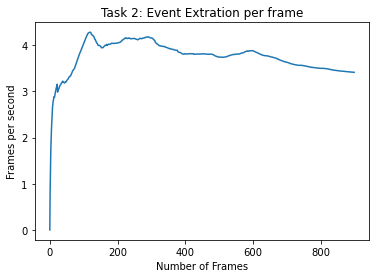

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(0,total),frame_per_second)
plt.title('Task 2: Event Extration per frame')
plt.xlabel('Number of Frames')
plt.ylabel('Frames per second')
plt.show()

## OPTIMIZATION: Q2

In [21]:
#Pipeline optimization using Producer Consumer - [5]

from threading import Thread, Condition
import time
import random

queue = []
total_cars_opt = []
total_suv_opt = []
total_sedan_opt = []
frame_per_second_opt = []
count = 0
cap = cv2.VideoCapture('assignment-clip.mp4')

query_start = time.perf_counter()
start = time.perf_counter()
#frame_start = 0

_, frame = cap.read()
h, w = frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
out = cv2.VideoWriter("Devishree_optimization_output.mp4", fourcc, 20.0, (w, h))

try:
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
except:
    print("Could not determine # of frames in video")

condition = Condition()


class ProducerThread(Thread):
    def run(self):
        
        global queue
        global count
        global cap
        global total
        global total_cars_opt 
        global total_suv_opt
        global total_sedan_opt
        global frame_per_second_opt
        global query_start
        global out
        
        while cap.isOpened():
            #try:
            condition.acquire() 

            frame_returned, frame = cap.read()
                        
            if frame_returned: 
                
                queue.append(frame)
                
                condition.notify()
                condition.release()
                time.sleep(random.random())
                
            else:
                cap.release()
                out.release()
                
                print("**",((count)*100)/total,"% completed **")
                
                output2_opt = pd.DataFrame(columns = ['Sedan','SUV','Total Cars'])
                output2_opt['SUV'] = total_suv_opt
                output2_opt['Sedan'] = total_sedan_opt
                output2_opt['Total Cars']=total_cars_opt
                task2_opt_output = pd.DataFrame(output2_opt)
                task2_opt_output.to_csv("Devishree_optimization_output.csv",mode='w+')

                query_end = time.perf_counter()
                print("Post Optimization: Average Throughput is ",round((sum(frame_per_second_opt))/total,2)," frames processed per second")
                print("Post Optimization: Time taken to execute full query: ",round(query_end-query_start,2)," seconds") 
                
                break
                
class ConsumerThread(Thread):
    def run(self):
        global queue
        global count
        global cap 
        global total
        global start
        global frame_start
        global out
        
        time_per_frame_opt = []

        while True:
            try:
                condition.acquire()
                if not queue:
                    print ("Nothing in queue, consumer is waiting")
                    condition.wait()
                    
                    print ("Producer added something to queue and notified the consumer")
                     
                sedan_count = 0
                suv_count = 0
                    
                frame = queue.pop(0)
                frame_start = time.perf_counter()

                H, W = frame.shape[:2]

                #create 4D blob from input frame & do a forward pass of YOLO
                blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),swapRB=True, crop=False)
                net.setInput(blob)
                layerOutputs = net.forward(ln)

                boxes = []
                confidences = []
                classIDs = []

                # loop over each layer outputs
                for output in layerOutputs:

                    # loop over each of detected objects
                    for detection in output:

                        # extract the class id (label) and confidence (as a probability) of
                        # the current object detection
                        scores = detection[5:]
                        classID = np.argmax(scores)
                        confidence = scores[classID]

                        if confidence > CONFIDENCE:
                            box = detection[0:4] * np.array([W, H, W, H])
                            (centerX, centerY, width, height) = box.astype("int")

                            x = int(centerX - (width / 2))
                            y = int(centerY - (height / 2))

                            boxes.append([x, y, int(width), int(height)])
                            confidences.append(float(confidence))
                            classIDs.append(classID)
                idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

                if len(idxs) > 0:

                    for i in idxs.flatten():
                        if(detect_cars(classIDs[i])):
                            (x, y) = (boxes[i][0], boxes[i][1])
                            (w, h) = (boxes[i][2], boxes[i][3])
                            crop_img = frame[y:y+h, x:x+w]
                            crop_img=crop_img/255.0

                            model_name = predict_model(crop_img)
                            if(model_name == "suv"):
                                suv_count += 1
                            elif(model_name == "sedan"):
                                sedan_count += 1

                        cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,255), 2)                
                        text = "{}: {:.4f}".format(model_name, confidences[i])
                        cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255,255), 2)

                elapsed_time = time.perf_counter() - start
                fps = count / elapsed_time

                time_per_frame_opt = [].append(elapsed_time)
                frame_per_second_opt.append(fps)   

                annotation = "Frame no: "+str(count+1)+"\nTotal suv: "+str(suv_count)+"\nTotal sedan: "+str(sedan_count)+"\nTotal cars: "+str(suv_count+sedan_count)+"\nFPS: "+str(round(fps,2))
                y0, dy = 50, 20
                for i, line in enumerate(annotation.split('\n')):
                    y = y0 + i*dy
                    cv2.putText(frame, line, (50, y ), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 0), 1)

                total_cars_opt.append(suv_count+sedan_count)
                total_suv_opt.append(suv_count)
                total_sedan_opt.append(sedan_count)
                out.write(frame)

                complete_status = (count/total)*100

                if(count == 0):
                    print("Processing Video")
                    print("**",count,"% completed **")
                elif(complete_status % 25 == 0):
                    print("**",complete_status,"% completed **")

                count += 1 # this advances one second
                cap.set(1, count)
                       
                
                condition.notify()
                
            finally:
                
                condition.release()
                time.sleep(random.random())


ProducerThread().start()
ConsumerThread().start()


Processing Video
** 0 % completed **
Nothing in queue, consumer is waiting
Producer added something to queue and notified the consumer
** 25.0 % completed **
** 50.0 % completed **
** 75.0 % completed **
** 100.0 % completed **
Post Optimization: Average Throughput is  1.34  frames processed per second
Post Optimization: Time taken to execute full query:  660.93  seconds


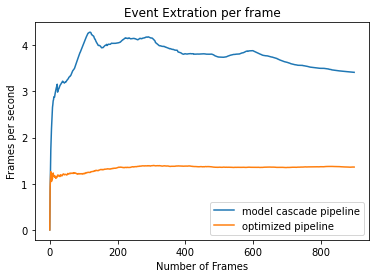

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(0,total),frame_per_second,label = "model cascade pipeline")
plt.plot(range(0,total),frame_per_second_opt,label = "optimized pipeline")
plt.title('Event Extration per frame')
plt.xlabel('Number of Frames')
plt.ylabel('Frames per second')
plt.legend()
plt.show()

In [23]:
#Comparing model to groundtruth data
y_truth_total = groundtruth['Total'].values
y_pred_total_opt = np.array(total_cars_opt)

y_truth_suv = groundtruth['SUV'].values
y_pred_suv_opt = np.array(total_suv_opt)

y_truth_sedan = groundtruth['Sedan'].values
y_pred_sedan_opt = np.array(total_sedan_opt)

In [24]:
#Calculating Accuracy of the model
print("For Optimized Pipeline:")
Total_accr_opt = metrics.accuracy_score(y_truth_total, y_pred_total_opt)*100
print("Total car count Accuracy = ",round(Total_accr_opt,2),"%")

SUV_accr_opt = metrics.accuracy_score(y_truth_suv, y_pred_suv_opt)*100
print("SUV count Accuracy = ",round(SUV_accr_opt,2),"%")

Sedan_accr_opt = metrics.accuracy_score(y_truth_sedan, y_pred_sedan_opt)*100
print("Sedan count Accuracy = ",round(Sedan_accr_opt,2),"%")

For Optimized Pipeline:
Total car count Accuracy =  22.67 %
SUV count Accuracy =  33.78 %
Sedan count Accuracy =  27.0 %


In [25]:
#Calculating F1 score for the model
print("For Optimized Pipeline:")
total_f1_opt = round(calculate_f1(y_truth_total,y_pred_total_opt),2)
print("F1 score for Total Car count = ",total_f1_opt)

SUV_f1_opt = round(calculate_f1(y_truth_suv, y_pred_suv_opt),2)
print("F1 score for SUV count = ",SUV_f1_opt)

Sedan_f1_opt = round(calculate_f1(y_truth_sedan, y_pred_sedan_opt),2)
print("F1 score for Sedan count = ",Sedan_f1_opt)

For Optimized Pipeline:
F1 score for Total Car count =  0.63
F1 score for SUV count =  0.48
F1 score for Sedan count =  0.24


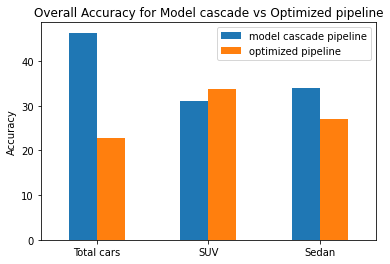

In [26]:
import matplotlib.pyplot as plt

accuracy_plot = pd.DataFrame({
    "model cascade pipeline": [Total_accr,SUV_accr,Sedan_accr],
    "optimized pipeline":[Total_accr_opt,SUV_accr_opt,Sedan_accr_opt]
    },
    index = ["Total cars","SUV","Sedan"]
)

accuracy_plot.plot.bar(rot=0) 
plt.title('Overall Accuracy for Model cascade vs Optimized pipeline')
plt.ylabel('Accuracy')
plt.show()

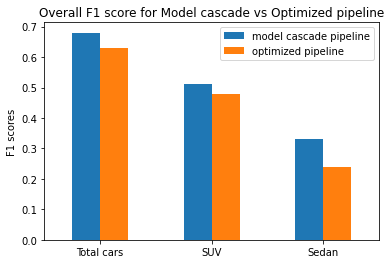

In [27]:
import matplotlib.pyplot as plt

f1_plot = pd.DataFrame({
    "model cascade pipeline": [total_f1,SUV_f1,Sedan_f1],
    "optimized pipeline":[total_f1_opt,SUV_f1_opt,Sedan_f1_opt]
    },
    index = ["Total cars","SUV","Sedan"]
)

f1_plot.plot.bar(rot=0) 
plt.title('Overall F1 score for Model cascade vs Optimized pipeline')
plt.ylabel('F1 scores')
plt.show()

### References / Citations

[1] https://www.thepythoncode.com/code/yolo-object-detection-with-opencv-and-pytorch-in-python <br>
[2] https://pypi.org/project/bing-image-downloader/
devis[4] https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/cnn_transfer_learning.ipynb <br>
[3] https://www.agiliq.com/blog/2013/10/producer-consumer-problem-in-python/